## Objective
- Predicted the digit using the image from MNIST
- Get an accuracy of over 99.4, satisfying the following constraints
    - [x] Should achieve the required accuracy using 20K or less parameters
    - [x] Should be under 20 epochs
    - [x] Have to use BatchNormalization, Dropout and Fully Connected Layer after GAP

## Imports

In [3]:
# PyTorch, everything from PyTorch can be referred with this
import torch

# Import the neural network model seperately
import torch.nn as nn

# Contains functions that are required such as ReLu (Activation function)
import torch.nn.functional as F 

# Optimizers required to converge using Backpropogation
import torch.optim as optim

# Datasets are used to download and load the data
# used to train and validate
# Transforms can be used to define modifications and/or augmentations methods
# to be applied while passing the data
# Normalization can also be one of the compositions of transforms
import torchvision
from torchvision import datasets, transforms

# Dataset abstract class using which custom dataset classes can be created
# DataLoader to create batches and to shuffle the data
from torch.utils.data import Dataset, DataLoader

# Visualize the images
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid # ImageGrid to form a grid of images

# Utils
import numpy as np
import seaborn as sns

## Load the dataset
Define a class a that loads and takes the images from MNIST to use as input along with the actual label of the handwritten digit which constitutes the required output

In [4]:
class MNISTDataset (Dataset):
    ''' Extending the Dataset class to provide customized inputs and modified 
    outputs for training '''

    def __init__(self, mode='training'):
        ''' Get/Download the data (MNIST) and setup up other configurations
        required to get the data
        
        Parameters:
            mode - Indicates either 'training' or 'validation'
        '''

        # Start by initializing the base class
        super().__init__()

        # Save the mode
        # Check if the mode is valid
        assert mode in ['training', 'validation'], \
            '"mode" should be either "training" or "validation"'
        self.mode = mode

        # Seed the random generator to results that are reproduceable
        # Remove during production
        torch.manual_seed(1)

        # Get MNIST data
        if self.mode == 'training':        
            # Define the transformations
            #   First convert into a tensor and then normalization
            #   Values for normalization where got from 
            #   https://discuss.pytorch.org/t/normalization-in-the-mnist-example/457
            self.transforms = transforms.Compose ([transforms.ToTensor (),
                                                   transforms.Normalize((0.1307,), 
                                                                        (0.3081,))])
        
            # Download the training set and store it at the root directory
            self.data = datasets.MNIST (root='./data/train/',
                                               train=True,
                                               download=True,
                                               transform=self.transforms)
            
        elif self.mode == 'validation':
            # Both the train and validation transforms are the same, but might decide 
            # to update with some data augmentation methods for train later
            # so keeping it seperate
            self.transforms = transforms.Compose ([transforms.ToTensor (),
                                                   transforms.Normalize((0.1307,), 
                                                                        (0.3081,))])
            
            # Get the validation set
            self.data = datasets.MNIST (root='./data/val/',
                                                  train=False,
                                                  download=True,
                                                  transform=self.transforms)
        

    def __len__(self):
        ''' Get the total size of the dataset '''
        return len (self.data)


    def __getitem__(self, index):
        ''' Used to get the index-th item from the dataset 
        
        Parameters:
            index - Element value to retrieve from the data
        '''

        # Check if the within the bounds of the data
        assert index < len (self.data), 'The index value is out-of-bound'

        # Index into the data to get the image and the corresponding label
        img, label = self.data [index]

        # Return the training set and the corresponding label
        return img, label

### Visualize the samples

In [5]:
# Define an object of the class 
# Set the "mode" to training
sample_data = MNISTDataset (mode='training')

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/train/MNIST/raw/train-images-idx3-ubyte.gz to ./data/train/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/train/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/train/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/train/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/train/MNIST/raw




Extracting ./data/train/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/train/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


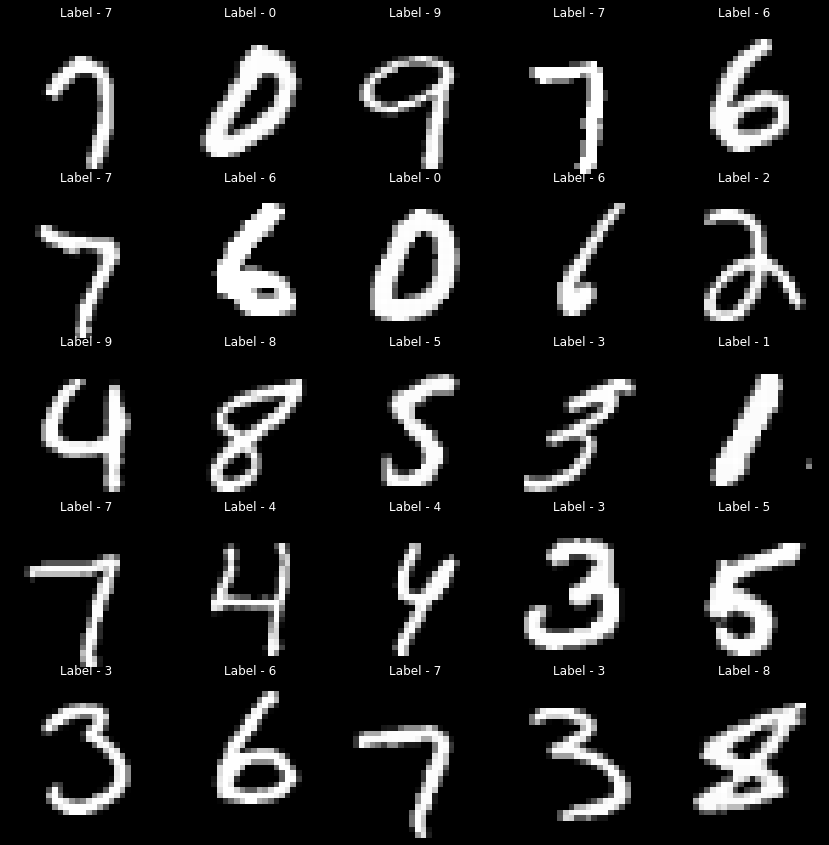

In [6]:
plt.style.use ('dark_background') # Dark mode rocks!!!

# Display random images from the dataset
fig = plt.figure(figsize=(15, 15))
grid = ImageGrid(fig, 111, 
                 nrows_ncols=(5, 5),
                 axes_pad=0.1)

for ax, idx in zip (grid, torch.randint (0, len (sample_data), size=(1, 25))[0]):
    # Get the image and label
    img, label = sample_data [idx]

    # Display the image with the label
    ax.imshow (img.view (28, 28), cmap='gray')
    ax.set_title (f'Label - {label}')
    ax.axis ('off');

### Explore the data
Try to find if optimal receptive field after which MaxPooling can be applied. Ideally for an image of size `400x400`, we would have to go uptill `11x11` to detect most of the required edges/gradients but since the size of the image is `28x28`, the required RF would be around `5x5` or `7x7`.

In [7]:
# For a sample of 1000 random images, compute the number of pixels horizontally and veritically
# to get what the size of the Receptive Field should be before applying MaxPooling

# Define the number of samples
no_of_samples = 1000

# Get `no_of_samples` images and compute RF size required
# To do so, calculate the distance (in pixels) of the lowest point to the 
# highest point, vertically and horizontally

# Store the results
horizontal_distance, vertical_distance = {}, {}

# Iterate through the samples
for idx in torch.randint (0, len (sample_data), size=(1, no_of_samples))[0]:
    # Get the image and label
    img, label = sample_data [idx]

    # Compute the vertical distance
    # Check for values that are not equal to the min (i.e. the background)
    # Since most of the values are the background values, this approach would be faster compute
    horizontal, vertical = np.where (img.reshape (28, 28) != img.min ())

    # Start with horizontal distance
    i, prev_ele = 0, horizontal [0]
    for j, ele in enumerate (horizontal):
        if ele != prev_ele:
            # Compute and store the distance
            try:
                horizontal_distance [label].append (j-i)
            except KeyError:
                horizontal_distance [label] = [j-i]

            # Save the results of the all the digits
            try:
                horizontal_distance ['all'].append (j-i)
            except KeyError:
                horizontal_distance ['all'] = [j-i]

            # Update the index
            i, prev_ele = j, ele

    # Calculate for vertical
    i, prev_ele = 0, vertical [0]
    for j, ele in enumerate (vertical):
        if ele != prev_ele+(j-i):
            # Compute and store the distance
            try:
                vertical_distance [label].append (j-i)
            except KeyError:
                vertical_distance [label] = [j-i]

            # Save the results of the all the digits
            try:
                vertical_distance ['all'].append (j-i)
            except KeyError:
                vertical_distance ['all'] = [j-i]

            # Update the index
            i, prev_ele = j, ele

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

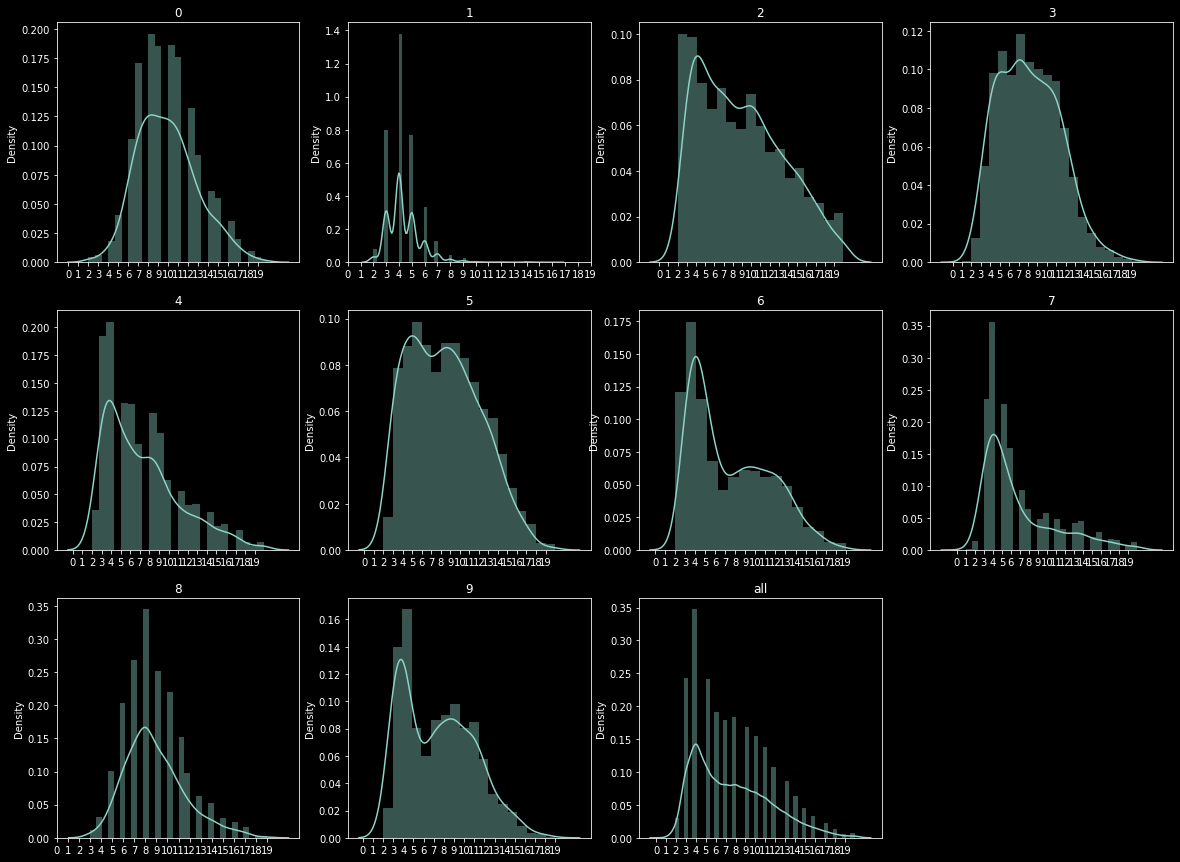

In [8]:
# Iterate through each labels to and display the results
plt.figure(figsize=(20, 15))

for i, k in enumerate (sorted (horizontal_distance.keys (), key=lambda x: str (x)[0]), start=1):
    plt.subplot (3, 4, i)
    sns.distplot (horizontal_distance [k])
    plt.xticks (range (20))
    plt.title (k)

**As seen above, most of the edges can be captured with `5x5`/`7x7` (Refer to the peak of the curve). So instead of having more layers, we can limit each block when this RF is reached.**

### Load the data
Define the data loaders for train and test with $batch\_size = 128$.

In [9]:
# Seed the random generator used by PyTorch
# so that the results are reproduceable
torch.manual_seed(1)

# Define the batch size to be used
# i.e. the number of images to be used per batch
batch_size = 128

# Set it to use GPU if available
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Define a dataloader 
# Set the batch_size and shuffle to select
# random images for every batch and epoch

# Parameters to be used while loading the data
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

train_loader = DataLoader (MNISTDataset (mode='training'),
                           batch_size=batch_size,
                           shuffle=True,
                           **kwargs)

test_loader = DataLoader (MNISTDataset (mode='validation'),
                           batch_size=batch_size,
                           shuffle=True,
                           **kwargs)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/val/MNIST/raw/train-images-idx3-ubyte.gz to ./data/val/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/val/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/val/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/val/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/val/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/val/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/val/MNIST/raw

Processing...
Done!


## Define the network architecture
The architecture should be able to predict the digit using the image from MNIST with the constraints applied


In [18]:
class MNISTNet(nn.Module):
    ''' Define a class initializing the layers constituting the required 
    CNN Architecture and the code for forward pass
    Note: The class extends to the nn.Module, which is a base class for 
    Neural Network modules in PyTorch https://pytorch.org/docs/stable/generated/torch.nn.Module.html
    '''

    def __init__(self, drop_perc=0.069):
        ''' Define the layers that constitute the network and
        initialize the base class '''

        # Start by initializing the base class
        super().__init__()

        # Store the dropout percentage
        self.drop_perc = drop_perc
    
        # Define the layers that make up the network
        # i.e. the Network Architecture
        # nn.Conv2d - Used to perform 2-dimensional convolution using the defined size of the kernel
        # nn.MaxPool2d - 2d MaxPooling Layer of the defined size

        # MNIST contains images of size 28x28
        # Since the images are padded, the resultant images after convolution
        # would have the same size
        # Block 1
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1, bias=False) # Input: 28x28x1; Output: 28x28x8; RF: 3x3
        self.bn1 = nn.BatchNorm2d (16)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1, bias=False) # Input: 28x28x8; Output: 28x28x16; RF: 5x5
        self.bn2 = nn.BatchNorm2d (32)
        #self.conv3 = nn.Conv2d(32, 64, 3, padding=1, bias=False) # Input: 28x28x16; Output: 28x28x32; RF: 7x7
        #self.bn3 = nn.BatchNorm2d (64)
        self.pool1 = nn.MaxPool2d(2, 2) # Input: 28x28x64; Output: 14x14x64; RF: 14x14
        self.one1 = nn.Conv2d (32, 8, 1, bias=False) # 1x1 conv; summarize the channels


        # Block 2
        self.conv4 = nn.Conv2d(8, 16, 3, padding=1, bias=False) # Input: 14x14x64; Output: 14x14x128; RF: 12x12 
        self.bn4 = nn.BatchNorm2d (16)
        #self.one_conv4 = nn.Conv2d (16, 16, 1, bias=False)
        self.conv5 = nn.Conv2d(16, 32, 3, padding=1, bias=False) # Input: 14x14x128; Output: 14x14x256; RF: 14x14 
        self.bn5 = nn.BatchNorm2d (32)
        self.pool2 = nn.MaxPool2d(2, 2) # Input: 14x14x256; Output: 7x7x256; RF: 24x24
        self.one2 = nn.Conv2d (32, 8, 1, bias=False) # 1x1 conv


        # Block 3
        self.conv6 = nn.Conv2d(8, 16, 3, padding=1, bias=False) # Input: 7x7x256; Output: 5x5x512; RF: 26x26
        self.bn6 = nn.BatchNorm2d (16)
        #self.one_conv6 = nn.Conv2d (32, 16, 1, bias=False)
        self.conv7 = nn.Conv2d(16, 32, 3, padding=1, bias=False) # Input: 5x5x512; Output: 3x3x1024; RF: 28x28
        self.bn7 = nn.BatchNorm2d (32)

        # Global Average Pooling
        self.gap = nn.AvgPool2d (7) # Input: 7x7x32; Output: 1x1x32;
        self.fc1 = nn.Linear (32, 64, bias=False)
        self.fc2 = nn.Linear (64, 10, bias=False)

        
    def forward(self, x):
        ''' Define the forward pass
        Each convolution layer is activated using ReLU to add non-linearity
        '''
        # Convolution layer followed by ReLU Activation, followed by Batch Normalization
        # followed by Dropout and then finally a pooling layer
        # Block 1
        x = F.dropout2d (self.bn1 (F.relu (self.conv1 (x))), self.drop_perc)
        x = F.dropout2d (self.bn2 (F.relu (self.conv2 (x))), self.drop_perc)
        #x = F.dropout2d (self.bn3 (F.relu (self.conv3 (x))), self.drop_perc)
        x = self.one1 (self.pool1 (x))

        # Convolution layer followed by ReLU Activation, followed by Batch Normalization
        # followed by Dropout and then finally a pooling layer
        # Block 2
        x = F.dropout2d (self.bn4 (F.relu (self.conv4 (x))), self.drop_perc)
        #x = self.one_conv4 (x)
        x = F.dropout2d (self.bn5 (F.relu (self.conv5 (x))), self.drop_perc)
        x = self.one2 (self.pool2 (x))
        
        # Convolution layer followed by ReLU Activation, followed by Batch Normalization
        # followed by Dropout and then finally a pooling layer
        # Block 3
        x = F.dropout2d (self.bn6 (F.relu (self.conv6 (x))), self.drop_perc)
        #x = self.one_conv6 (x)
        x = F.dropout2d (self.bn7 (F.relu (self.conv7 (x))), self.drop_perc)

        # The final layer shouldn't be passed through ReLU, but should be retained
        # Using Global Average Pooling to reduce the final output size
        x = self.gap (x)

        # Pass through a few FC layers to get the output
        x = F.dropout (F.relu (self.fc1 (x.view (-1, 32))), self.drop_perc)
        x = self.fc2 (x)

        # Reshape to fit the output and return
        x = x.view(-1, 10)
        return F.log_softmax(x)

In [19]:
# To display an overview/summary of the network
# Is also useful to validate whether the structure of the network is 
# correct, i.e. the input channels and the output channels and its flow
!pip install torchsummary
from torchsummary import summary

# Create a model object
model = MNISTNet(drop_perc=0.01).to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             144
       BatchNorm2d-2           [-1, 16, 28, 28]              32
            Conv2d-3           [-1, 32, 28, 28]           4,608
       BatchNorm2d-4           [-1, 32, 28, 28]              64
         MaxPool2d-5           [-1, 32, 14, 14]               0
            Conv2d-6            [-1, 8, 14, 14]             256
            Conv2d-7           [-1, 16, 14, 14]           1,152
       BatchNorm2d-8           [-1, 16, 14, 14]              32
            Conv2d-9           [-1, 32, 14, 14]           4,608
      BatchNorm2d-10           [-1, 32, 14, 14]              64
        MaxPool2d-11             [-1, 32, 7, 7]               0
           Conv2d-12              [-1, 8, 7, 7]             256
           Conv2d-13             [-1, 16, 7, 7]           1,152
      BatchNorm2d-14             [-1, 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


### Train and Validate

In [33]:
# TQDM is just awesome... provides a progress status bar as the training 
# (or any operation) proceeds
from tqdm import tqdm

def test(model, device, test_loader, set_name='Test'):
    ''' Validate the trained model on a hold-out set '''

    # Set the model to evalution mode
    model.eval()

    # Initialize the losses
    # and the no of correct predictions to 0
    test_loss = 0
    correct = 0

    # Disable the gradient computations
    # While evaulating only forward pass is used and the backward pass
    # along with the gradient (likewise the gradient update) isn't required
    with torch.no_grad():
        # Iterate over the test/validation set
        for data, target in test_loader:
            # Converting the data to the required type 
            # (PyTorch Cuda Tensor while using GPU)
            # Convert the target from one-hot encoded vector to an it
            data = data.to(device)
            target = target.to(device)

            # Get the predictions
            output = model(data)

            # Compute the loss against the target
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss

            # Get the index of the prediction
            # i.e. the output is one-hot encoded, so get the argument with the max
            # log probability
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability

            # Get a count of the correct preditcions
            correct += pred.eq(target.view_as(pred)).sum().item()

    # Compute the final loss on the test/validation data
    test_loss /= len(test_loader.dataset)

    # Display the results
    print('\n{} set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        set_name, test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    # Return the loss
    # Can be used to update the learning rate
    return test_loss


def train(model, device, train_loader, optimizer, epoch, scheduler=None):
    ''' Define the training steps '''

    # Set the model to training mode
    model.train()

    # Initialize the progress bar
    pbar = tqdm(train_loader)

    # Init the correct predictions to 0
    correct = 0

    # Start iterating through the training data
    for batch_idx, (data, target) in enumerate(pbar):
        # Start by converting the data to the required type 
        # (PyTorch CUDA Tensor while using GPU)
        # Convert the target from one-hot encoded vector to an it
        data = data.to(device)
        target = target.to(device)

        # Discard/reset the gradients from the previous iteration
        optimizer.zero_grad()

        # Get the predictions for the given data
        output = model(data)

        # Compute the negative loss likelihood of the predictions vs the actuals
        # and propogate the loss backwards (back propogation)
        loss = F.nll_loss(output, target)
        loss.backward()

        # Use the optimizer to take a step in the -ve of the gradient direction
        # by the amount equal to the gradient magnitude times the learning rate 
        optimizer.step()

        # Update the progress bar
        pbar.set_description(desc=f'Loss={loss.item():.4f}; Batch_id={batch_idx}; ' + \
                             f'Learning Rate={optimizer.param_groups[0]["lr"]:.4f}')

    # Update the learning rate after each training cycle
    if scheduler:
        scheduler.step ()

    # Get the correct prediction to calculate the training accuracy
    test (model, device, train_loader, set_name='Train')

In [36]:
# Initialize the model instance
model = MNISTNet(drop_perc=0.008).to(device)

# Define an optimizer to use to perform gradient descent
# Various optimizers are suitable for different usecase, which help
# reach the global optimal (i.e. a model with least errors/loss) quickly
# In this case, Stochastic Gradient Descent (SGD) is used with momentum of 0.9
# and the learning rate (alpha) set to 0.01 
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)

# Define a learning rate scheduler
# Refered from: https://www.kaggle.com/isbhargav/guide-to-pytorch-learning-rate-scheduling
# and https://pytorch.org/docs/master/optim.html
# https://pytorch.org/docs/master/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html#torch.optim.lr_scheduler.ReduceLROnPlateau
# Decrease the learning rate after a particular step
plat_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                      factor=0.05, patience=2, 
                                                      min_lr=0.0001, threshold=0.001, 
                                                      verbose=True)

multistep_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, 
                                                 milestones=[6, 13, 17], gamma=0.5, verbose=True)


# Set the epochs
epochs = 20

# Train the model for epochs no. of times
for epoch in range(0, epochs):
    print (f'Iteration {epoch+1}')
    # Initiate training phase
    train(model, device, train_loader, optimizer, epoch, multistep_scheduler)

    # Validate the results on the test/validation set
    loss = test(model, device, test_loader)

    # Update the learning rate
    plat_scheduler.step (loss)

    print ('\n')

  0%|          | 0/469 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.0000e-02.
Iteration 1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=0.2365; Batch_id=468; Learning Rate=0.0500: 100%|██████████| 469/469 [00:12<00:00, 37.73it/s]

Adjusting learning rate of group 0 to 5.0000e-02.



Train set: Average loss: 0.0841, Accuracy: 58510/60000 (97.52%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0838, Accuracy: 9744/10000 (97.44%)



Iteration 2


Loss=0.0631; Batch_id=468; Learning Rate=0.0500: 100%|██████████| 469/469 [00:12<00:00, 37.65it/s]

Adjusting learning rate of group 0 to 5.0000e-02.



Train set: Average loss: 0.0523, Accuracy: 59025/60000 (98.38%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0559, Accuracy: 9822/10000 (98.22%)



Iteration 3


Loss=0.1036; Batch_id=468; Learning Rate=0.0500: 100%|██████████| 469/469 [00:12<00:00, 38.02it/s]

Adjusting learning rate of group 0 to 5.0000e-02.



Train set: Average loss: 0.0513, Accuracy: 59025/60000 (98.38%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0493, Accuracy: 9848/10000 (98.48%)



Iteration 4


Loss=0.0086; Batch_id=468; Learning Rate=0.0500: 100%|██████████| 469/469 [00:12<00:00, 37.02it/s]

Adjusting learning rate of group 0 to 5.0000e-02.



Train set: Average loss: 0.0283, Accuracy: 59466/60000 (99.11%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0346, Accuracy: 9890/10000 (98.90%)



Iteration 5


Loss=0.0160; Batch_id=468; Learning Rate=0.0500: 100%|██████████| 469/469 [00:12<00:00, 38.34it/s]

Adjusting learning rate of group 0 to 5.0000e-02.



Train set: Average loss: 0.0224, Accuracy: 59596/60000 (99.33%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0284, Accuracy: 9912/10000 (99.12%)



Iteration 6


Loss=0.0863; Batch_id=468; Learning Rate=0.0500: 100%|██████████| 469/469 [00:12<00:00, 37.73it/s]

Adjusting learning rate of group 0 to 2.5000e-02.



Train set: Average loss: 0.0259, Accuracy: 59480/60000 (99.13%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0323, Accuracy: 9890/10000 (98.90%)



Iteration 7


Loss=0.0027; Batch_id=468; Learning Rate=0.0250: 100%|██████████| 469/469 [00:12<00:00, 37.97it/s]

Adjusting learning rate of group 0 to 2.5000e-02.



Train set: Average loss: 0.0144, Accuracy: 59725/60000 (99.54%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9923/10000 (99.23%)



Iteration 8


Loss=0.0391; Batch_id=468; Learning Rate=0.0250: 100%|██████████| 469/469 [00:12<00:00, 37.90it/s]

Adjusting learning rate of group 0 to 2.5000e-02.



Train set: Average loss: 0.0115, Accuracy: 59791/60000 (99.65%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9924/10000 (99.24%)



Iteration 9


Loss=0.0106; Batch_id=468; Learning Rate=0.0250: 100%|██████████| 469/469 [00:12<00:00, 38.08it/s]

Adjusting learning rate of group 0 to 2.5000e-02.



Train set: Average loss: 0.0103, Accuracy: 59828/60000 (99.71%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9932/10000 (99.32%)



Iteration 10


Loss=0.0408; Batch_id=468; Learning Rate=0.0250: 100%|██████████| 469/469 [00:12<00:00, 38.25it/s]

Adjusting learning rate of group 0 to 2.5000e-02.



Train set: Average loss: 0.0116, Accuracy: 59790/60000 (99.65%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9928/10000 (99.28%)



Iteration 11


Loss=0.0223; Batch_id=468; Learning Rate=0.0250: 100%|██████████| 469/469 [00:12<00:00, 38.08it/s]

Adjusting learning rate of group 0 to 2.5000e-02.



Train set: Average loss: 0.0127, Accuracy: 59753/60000 (99.59%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0280, Accuracy: 9908/10000 (99.08%)



Iteration 12


Loss=0.0037; Batch_id=468; Learning Rate=0.0250: 100%|██████████| 469/469 [00:12<00:00, 37.52it/s]

Adjusting learning rate of group 0 to 2.5000e-02.



Train set: Average loss: 0.0093, Accuracy: 59840/60000 (99.73%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9937/10000 (99.37%)



Iteration 13


Loss=0.0012; Batch_id=468; Learning Rate=0.0250: 100%|██████████| 469/469 [00:12<00:00, 37.58it/s]

Adjusting learning rate of group 0 to 1.2500e-02.



Train set: Average loss: 0.0080, Accuracy: 59854/60000 (99.76%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 9924/10000 (99.24%)



Iteration 14


Loss=0.0182; Batch_id=468; Learning Rate=0.0125: 100%|██████████| 469/469 [00:12<00:00, 38.27it/s]

Adjusting learning rate of group 0 to 1.2500e-02.



Train set: Average loss: 0.0061, Accuracy: 59903/60000 (99.84%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0182, Accuracy: 9937/10000 (99.37%)



Iteration 15


Loss=0.0071; Batch_id=468; Learning Rate=0.0125: 100%|██████████| 469/469 [00:12<00:00, 37.86it/s]

Adjusting learning rate of group 0 to 1.2500e-02.



Train set: Average loss: 0.0062, Accuracy: 59898/60000 (99.83%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9934/10000 (99.34%)



Iteration 16


Loss=0.0005; Batch_id=468; Learning Rate=0.0125: 100%|██████████| 469/469 [00:12<00:00, 37.27it/s]

Adjusting learning rate of group 0 to 1.2500e-02.



Train set: Average loss: 0.0053, Accuracy: 59918/60000 (99.86%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9927/10000 (99.27%)



Iteration 17


Loss=0.0051; Batch_id=468; Learning Rate=0.0125: 100%|██████████| 469/469 [00:12<00:00, 37.11it/s]

Adjusting learning rate of group 0 to 6.2500e-03.



Train set: Average loss: 0.0055, Accuracy: 59906/60000 (99.84%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0173, Accuracy: 9941/10000 (99.41%)



Iteration 18


Loss=0.0005; Batch_id=468; Learning Rate=0.0063: 100%|██████████| 469/469 [00:12<00:00, 37.04it/s]

Adjusting learning rate of group 0 to 6.2500e-03.



Train set: Average loss: 0.0044, Accuracy: 59933/60000 (99.89%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9940/10000 (99.40%)



Iteration 19


Loss=0.0026; Batch_id=468; Learning Rate=0.0063: 100%|██████████| 469/469 [00:12<00:00, 37.23it/s]

Adjusting learning rate of group 0 to 6.2500e-03.



Train set: Average loss: 0.0038, Accuracy: 59947/60000 (99.91%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0180, Accuracy: 9944/10000 (99.44%)



Iteration 20


Loss=0.0185; Batch_id=468; Learning Rate=0.0063: 100%|██████████| 469/469 [00:12<00:00, 37.47it/s]

Adjusting learning rate of group 0 to 6.2500e-03.



Train set: Average loss: 0.0041, Accuracy: 59939/60000 (99.90%)


Test set: Average loss: 0.0176, Accuracy: 9943/10000 (99.43%)

Epoch    20: reducing learning rate of group 0 to 3.1250e-04.




## Architecture tried out

- Squeeze and Expand Architecture with 
    - Dropout - 0.1 
    - 1x1 after each block
    - 7x7 RF for Block 1
    - Parameters - 20,856
    - **Best Accuracy - 98.60%** 


- Squeeze and Expand Architecture with 
    - Dropout - 0.05
    - 1x1 after each block
    - 7x7 RF for Block 1
    - Parameters - 20,856
    - **Best Accuracy - 99.11%**
    


- Squeeze and Expand Architecture with 
    - Dropout - 0.05
    - 1x1 after each block
    - 7x7 RF for Block 1
    - Parameters - 19,760
    - **Best Accuracy - 99.12%**
    


- Squeeze and Expand Architecture with 
    - Dropout - 0.01
    - 1x1 after each block
    - 5x5 RF for Block 1
    - Parameters - 19,760
    - **Best Accuracy - 99.27%**
    


- Squeeze and Expand Architecture with 
    - Dropout - 0.008
    - 1x1 after each block
    - 5x5 RF for Block 1
    - Parameters - 19,760
    - **Best Accuracy - 99.32%**
    


- Squeeze and Expand Architecture with 
    - Dropout - 0.008
    - 1x1 after each block
    - 5x5 RF for Block 1
    - Parameters - 19,760
    - With Learning Rate Schedulers
        - MultiStep LR Scheduler
        - Reduce on Plateau
    - **Best Accuracy - 99.44%**
